In [4]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import os
os.getcwd()

'/home/mcw/subha/distdriver-woverlap/Distracted-Driver-Detection'

In [1]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
#Use the generated model 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


In [15]:
driver_details = pd.read_csv('../../statefarm_dataset/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))



  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [3]:
def grab(image): 
    mask = np.zeros(image.shape[:2],np.uint8)
#     print(mask.shape)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    w = image.shape[0]
    h = image.shape[1]
    x,y,w,h = 1,1,w-1,h-1
    rect = (x,y,w,h)
    
    cv2.grabCut(image,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    image = image*mask2[:,:,np.newaxis]
    
    return image

In [16]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("../../statefarm_dataset/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "../../statefarm_dataset/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
#         img = grab(img)
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)
#         plt.imshow(img)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [17]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

driv_selected = ['p050', 'p015', 'p022', 'p056']

In [18]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


18732 3692
18732 3692
(18732, 224, 224, 3)


In [6]:
## Defining the input

from tensorflow.keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')



## The VGG model

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 
x = GlobalAveragePooling2D()(output_vgg16_conv)
x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout 
x = Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(inputs = vgg16_input, outputs = x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


### Running VGG with Image Aumentation

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import json
import datetime

checkpointer = ModelCheckpoint('logs_vgg16_all_layers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

log_dir="logs_vgg16_all_layers/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)



datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper, tensorboard_callback],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

model_json = vgg16_pretrained.to_json()
with open("model_vgg16_all_layers.json",'w') as json_file:
 	json_file.write(model_json)

vgg16_pretrained.save_weights("model_vgg16_all_layers.h5")
print("Model saved")


Epoch 1/25
292/292 [============================>.] - ETA: 0s - loss: 2.7830 - accuracy: 0.1174
Epoch 00001: val_loss improved from inf to 2.41348, saving model to logs_vgg16_all_layers.hdf5
293/292 [==============================] - 410s 1s/step - loss: 2.7820 - accuracy: 0.1177 - val_loss: 2.4135 - val_accuracy: 0.2010
Epoch 2/25
292/292 [============================>.] - ETA: 0s - loss: 2.3689 - accuracy: 0.1964
Epoch 00002: val_loss improved from 2.41348 to 1.66366, saving model to logs_vgg16_all_layers.hdf5
293/292 [==============================] - 188s 643ms/step - loss: 2.3680 - accuracy: 0.1968 - val_loss: 1.6637 - val_accuracy: 0.4006
Epoch 3/25
292/292 [============================>.] - ETA: 0s - loss: 1.7065 - accuracy: 0.4048
Epoch 00003: val_loss improved from 1.66366 to 0.97554, saving model to logs_vgg16_all_layers.hdf5
293/292 [==============================] - 185s 631ms/step - loss: 1.7055 - accuracy: 0.4053 - val_loss: 0.9755 - val_accuracy: 0.6506
Epoch 4/25
292/29

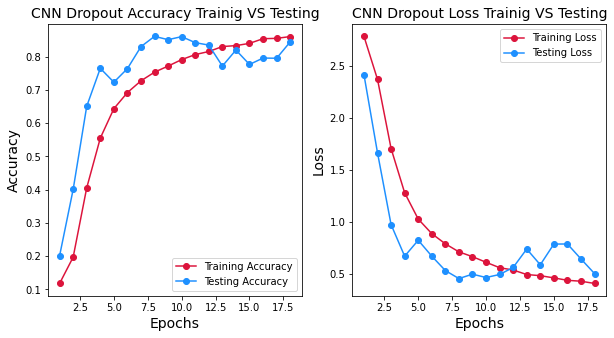

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

# MobileNet Model

In [7]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# base_model.summary()

x=base_model.output
x=GlobalAveragePooling2D()(x)

# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

# x = Dropout(0.1)(x) # ****reduce dropout 

# x=Dense(1024,activation='relu')(x) #dense layer 2

# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=preds)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128   

In [8]:

#adam = optimizers.Adam(lr=0.001) #tried 0.0005 - too slow and didn't converge
sgd = optimizers.SGD(lr = 0.005) # try 0.01 - didn't converge and 0.005 , 0.001 best acc of 11%

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy']) # create object


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import json
import datetime

checkpointer = ModelCheckpoint('mobilenetv1_manyaugs.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

log_dir="logs_mobilenetv1_manyaugs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30,
    shear_range=0.2,
    fill_mode='nearest'
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
mobilenet_model = model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper, tensorboard_callback],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

model_json = model.to_json()
with open("mobilenetv1_manyaugs.json",'w') as json_file:
 	json_file.write(model_json)

model.save_weights("mobilenetv1_manyaugs.h5")
print("Model saved")


Epoch 1/25
292/292 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.9500
Epoch 00001: val_loss improved from inf to 0.00094, saving model to mobilenetv1_manyaugs.hdf5
293/292 [==============================] - 306s 1s/step - loss: 0.2785 - accuracy: 0.9501 - val_loss: 9.3649e-04 - val_accuracy: 1.0000
Epoch 2/25
292/292 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.9974
Epoch 00002: val_loss improved from 0.00094 to 0.00021, saving model to mobilenetv1_manyaugs.hdf5
293/292 [==============================] - 216s 737ms/step - loss: 0.0422 - accuracy: 0.9974 - val_loss: 2.1186e-04 - val_accuracy: 1.0000
Epoch 3/25
292/292 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9987
Epoch 00003: val_loss improved from 0.00021 to 0.00011, saving model to mobilenetv1_manyaugs.hdf5
293/292 [==============================] - 180s 615ms/step - loss: 0.0240 - accuracy: 0.9987 - val_loss: 1.1128e-04 - val_accuracy: 1.0000
Epoch 4/

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['accuracy']) + 1), model.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_accuracy']) + 1), model.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

# MobileNet v2 with Image Aug

In [8]:
# Random Eraser
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

def blur(img):
    return (cv2.blur(img,(5,5)))

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base_model=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# base_model.summary()

x=base_model.output
x=GlobalAveragePooling2D()(x)

# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

# x = Dropout(0.1)(x) # ****reduce dropout 

# x=Dense(1024,activation='relu')(x) #dense layer 2

# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=preds)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [10]:

#adam = optimizers.Adam(lr=0.001) #tried 0.0005 - too slow and didn't converge
sgd = optimizers.SGD(lr = 0.005) # try 0.01 - didn't converge and 0.005 , 0.001 best acc of 11%

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy']) # create object


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import json
import datetime

checkpointer = ModelCheckpoint('mobilenet_sgd_imgaug_grab.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

log_dir="logs_mobilenet_sgd_imgaug_grab/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30,
    preprocessing_function=get_random_eraser(v_l=0, v_h=1)
    )

#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
mobilenet_model = model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper, tensorboard_callback],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

model_json = model.to_json()
with open("mobilenet_sgd_imgaug_grab.json",'w') as json_file:
 	json_file.write(model_json)

model.save_weights("mobilenet_sgd_imgaug_grab.h5")
print("Model saved")


Epoch 1/25
292/292 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.9420
Epoch 00001: val_loss improved from inf to 0.17639, saving model to mobilenet_sgd_imgaug_grab.hdf5
293/292 [==============================] - 433s 1s/step - loss: 0.3026 - accuracy: 0.9422 - val_loss: 0.1764 - val_accuracy: 0.9981
Epoch 2/25
292/292 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9926
Epoch 00002: val_loss improved from 0.17639 to 0.00611, saving model to mobilenet_sgd_imgaug_grab.hdf5
293/292 [==============================] - 185s 631ms/step - loss: 0.0494 - accuracy: 0.9926 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 3/25
292/292 [============================>.] - ETA: 0s - loss: 0.0321 - accuracy: 0.9937
Epoch 00003: val_loss improved from 0.00611 to 0.00166, saving model to mobilenet_sgd_imgaug_grab.hdf5
293/292 [==============================] - 186s 634ms/step - loss: 0.0322 - accuracy: 0.9936 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



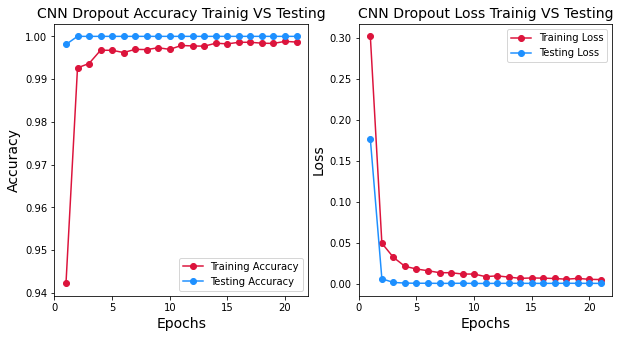

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['accuracy']) + 1), model.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_accuracy']) + 1), model.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [32]:
from tensorflow.keras.models import model_from_json

test = []

for img in test_image:
    test.append(img)


model.load_weights('mobilenet_sgd_imgaug.h5')


predict_test = np.array(test).reshape(-1,224,224,3).astype('float32')
prediction = model.predict(predict_test)

In [27]:
prediction[0]

array([1.9739872e-02, 9.4541758e-01, 1.1076719e-04, 2.1801454e-05,
       3.2754117e-05, 6.2773972e-05, 6.0140028e-05, 3.8647333e-05,
       2.7915265e-02, 6.6004461e-03], dtype=float32)

In [28]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

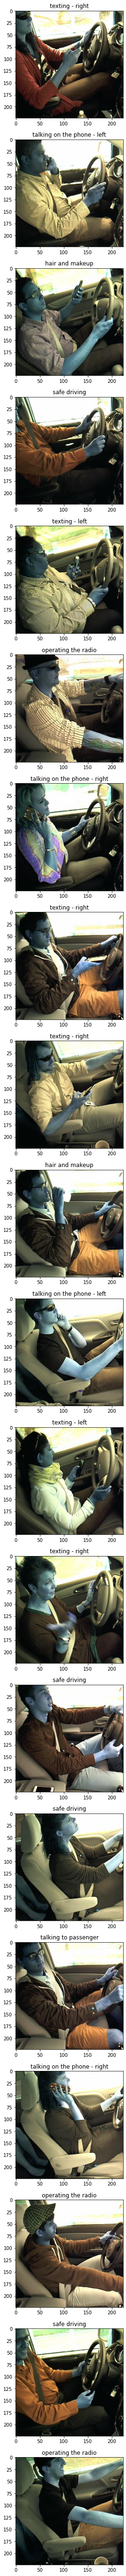

In [29]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i])
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show
    

# Scratch CNN

In [ ]:
## Designing the Layers
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', init='he_normal',
                            input_shape=(color_type, img_rows, img_cols)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(128, 3, 3, border_mode='same', init='he_normal'))
model.add(MaxPooling2D(pool_size=(8, 8)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = optimizers.SGD(lr = 0.005)
model.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

model.summary()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import json
import datetime

checkpointer = ModelCheckpoint('scratch_cnn_grab.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

log_dir="logs_scratch_cnn_grab/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

def blur(img):
    plt.imshow(img)
    return (cv2.blur(img,(5,5)))


datagen = ImageDataGenerator(
    
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30,
    preprocessing_function=blur
    
    
        )

data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper, tensorboard_callback],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

model_json = model.to_json()
with open("scratch_cnn_grab.json",'w') as json_file:
 	json_file.write(model_json)

model.save_weights("scratch_cnn_grab.h5")
print("Model saved")


# Efficient Net Model

In [16]:
from tensorflow.keras.applications import EfficientNet

# base_model = MobileNet(include_top=True,
#                             weights='imagenet')

ImportError: cannot import name 'EfficientNet' from 'tensorflow.keras.applications' (/home/mcw/anaconda3/envs/subhadms/lib/python3.7/site-packages/tensorflow_core/python/keras/api/_v2/keras/applications/__init__.py)

In [10]:
eff_model = Sequential()
eff_model.add(base_model)
eff_model.add(GlobalMaxPooling2D(name="gap"))
eff_model.add(Dense(10, activation="softmax", name="fc_out"))


eff_model.summary()

TypeError: The added layer must be an instance of class Layer. Found: <keras.engine.training.Model object at 0x7f1ff45e0b10>

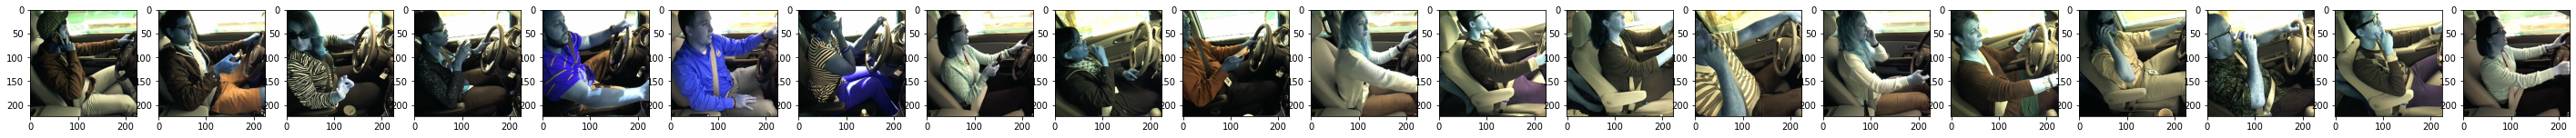

In [2]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('../../statefarm_dataset/test')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
#     print ('Image number:',i)
    img = cv2.imread('../../statefarm_dataset/test/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show


In [3]:
from tensorflow.keras.models import model_from_json


with open('models/mobilenet_sgd_nolayers.json','r') as f:
    model = model_from_json(f.read())
    
sgd = optimizers.SGD(lr = 0.001) # try 0.01 - didn't converge and 0.005 , 0.001 best acc of 11%

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

test = []

for img in test_image:
    test.append(img)






Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

[8.5703306e-07 5.5059169e-05 9.5194262e-01 1.4880144e-08 2.3730615e-07
 1.6006990e-05 1.2872285e-03 3.3311057e-04 4.6331279e-02 3.3469332e-05]


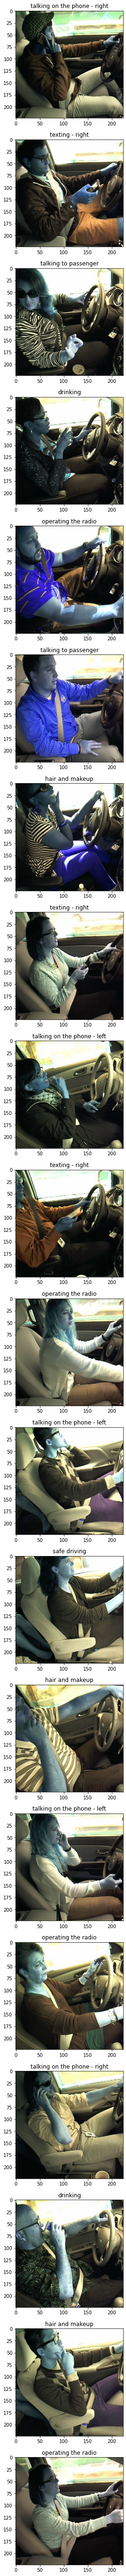

In [4]:

model.load_weights('models/mobilenet_sgd_nolayers.h5')


predict_test = np.array(test).reshape(-1,224,224,3).astype('float32')
prediction = model.predict(predict_test)
print(prediction[0])


# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i])
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show
    